In [1]:
import gc
import os
import random
import warnings
import numpy as np
import pandas as pd
from IPython.display import display

# PyTorch for deep learning
import timm
import torch
import torch.nn as nn  
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

# torchvision for image processing and augmentation
import torchvision.transforms as transforms

# Suppressing minor warnings to keep the output clean
warnings.filterwarnings('ignore', category=Warning)

# Reclaim memory no longer in use.
gc.collect()


# Configuration class containing hyperparameters and settings
class Config:
    seed = 42 
    image_transform = transforms.Resize((440,440))  
    batch_size = 50
    num_epochs = 10
    num_folds = 5

# Set the seed for reproducibility across multiple libraries
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(Config.seed)

# Define the 'Kullback Leibler Divergence' loss function
def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

# Reclaim memory no longer in use.
gc.collect()

# Load training data

PATH_OR = "C:\\Users\\marcb\\OneDrive\\Desktop\\Kaggle_Competitions\\Kaggle-Competitions\\HMS-harmful-brain-activity\\"
test_eeg = PATH_OR+'hms-harmful-brain-activity-classification/train_eegs/'
test_csv = PATH_OR+'hms-harmful-brain-activity-classification/train.csv'

df = pd.read_csv(test_csv)
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

	
	

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [2]:
%%time
READ_SPEC_FILES = False

# READ ALL SPECTROGRAMS
PATH = PATH_OR+'hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load(PATH_OR+'brain-spectograms/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: total: 2.09 s
Wall time: 2.12 s


In [3]:
%%time
READ_EEG_SPEC_FILES = False

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for i,e in enumerate(train.eeg_id.values):
        if i%100==0: print(i,', ',end='')
        x = np.load(f'/kaggle/input/brain-eeg-spectrograms/EEG_Spectrograms/{e}.npy')
        all_eegs[e] = x
else:
    all_eegs = np.load(PATH_OR+'brain-eeg-spectograms/eeg_specs.npy',allow_pickle=True).item()

CPU times: total: 2.81 s
Wall time: 2.87 s


In [18]:
import albumentations as albu
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as albu
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, data, mode='train', specs=spectrograms, eeg_specs=all_eegs, augment=False):
        self.data = data
        self.mode = mode
        self.specs = specs
        self.eeg_specs = eeg_specs
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        if self.mode == 'test':
            r = 0
        else:
            r = int((row['min'] + row['max']) // 4)
    
        X_tensor = torch.zeros((128, 256, 8), dtype=torch.float32)
        y_tensor = torch.zeros(6, dtype=torch.float32)
    
        for k in range(4):
            # EXTRACT 300 ROWS OF SPECTROGRAM
            img = self.specs[row.spec_id][r:r+300, k*100:(k+1)*100].T
    
            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)
    
            # STANDARDIZE PER IMAGE
            ep = 1e-6
            m = np.nanmean(img.flatten())
            s = np.nanstd(img.flatten())
            img = (img - m) / (s + ep)
            img = np.nan_to_num(img, nan=0.0)
    
            # CROP TO 256 TIME STEPS
            X_tensor[14:-14, :, k] = torch.from_numpy(img[:, 22:-22] / 2.0)
    
        # EEG SPECTROGRAMS
        #print(X_tensor.shape)
        img = self.eeg_specs[row.eeg_id]
        X_tensor[:, :, 4:] = torch.tensor(img)
        #print(list(row[TARGETS].values))
    
        if self.mode != 'test':
            y_tensor = torch.tensor(list(row[TARGETS].values))
    
        if self.augment:
            X_tensor = self.__random_transform(X_tensor)
    
        return X_tensor, y_tensor

    def __random_transform(self, img):
        composition = albu.Compose([
            albu.HorizontalFlip(p=0.5),
            # albu.VerticalFlip(p=0.5),
            # albu.CoarseDropout(max_holes=8, max_height=32, max_width=32, fill_value=0, p=0.5),
        ])
        return composition(image=img)['image']

def get_dataloader(data, batch_size=32, shuffle=False, augment=False, mode='train',
                   specs=spectrograms, eeg_specs=all_eegs):
    dataset = CustomDataset(data, mode, specs, eeg_specs, augment)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle,drop_last=True, num_workers=0)
    return dataloader

In [19]:
gen = get_dataloader(train, batch_size=32, shuffle=False)
next(iter(gen))

[tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.5732e-01,
             7.1159e-01,  4.1752e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.5355e-01,
             8.5029e-01,  5.0647e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  5.9274e-01,
             8.4416e-01,  6.3437e-01],
           ...,
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  8.8461e-01,
             7.0790e-01,  6.5807e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  8.5633e-01,
             8.1478e-01,  6.9364e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  8.2679e-01,
             7.9057e-01,  6.9236e-01]],
 
          [[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.5618e-01,
             7.1016e-01,  4.1605e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.7288e-01,
             8.4677e-01,  5.3049e-01],
           [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  5.9115e-01,
             8.3999e-01,  6.3037e-01],


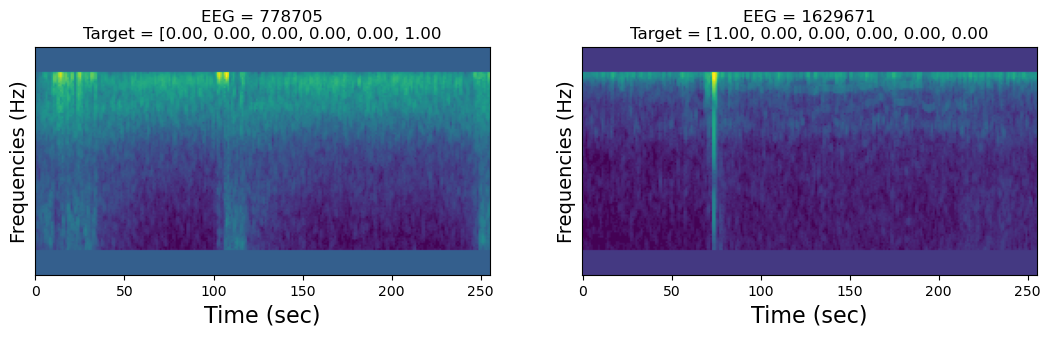

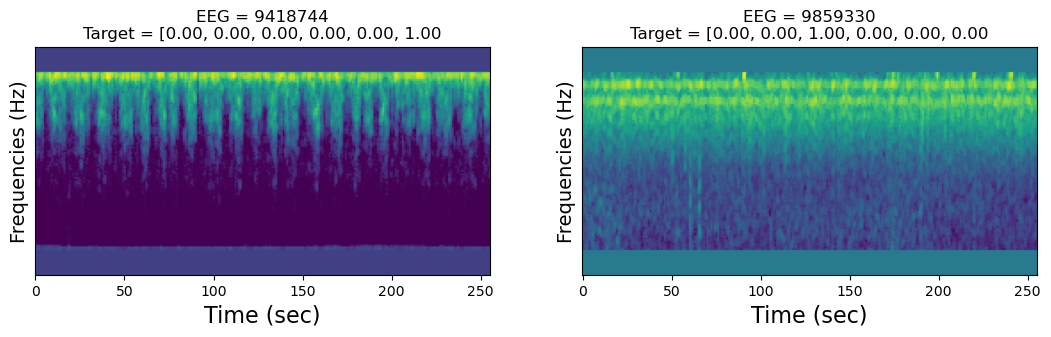

In [20]:
import matplotlib.pyplot as plt
gen = get_dataloader(train, batch_size=32, shuffle=False)
ROWS=2; COLS=3; BATCHES=2

for i,(x,y) in enumerate(gen):
    plt.figure(figsize=(20,8))
    for j in range(1,ROWS):
        for k in range(1,COLS):
            plt.subplot(ROWS,COLS,j*COLS+k+1)
            t = y[j*COLS+k]
            img = x[j*COLS+k,:,:,0]
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            tars = f'[{t[0]:0.2f}'
            for s in t[1:]: tars += f', {s:0.2f}'
            eeg = train.eeg_id.values[i*32+j*COLS+k]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    if i==BATCHES-1: break

In [7]:
x,y = next(iter(gen))
x.shape

torch.Size([32, 128, 256, 8])

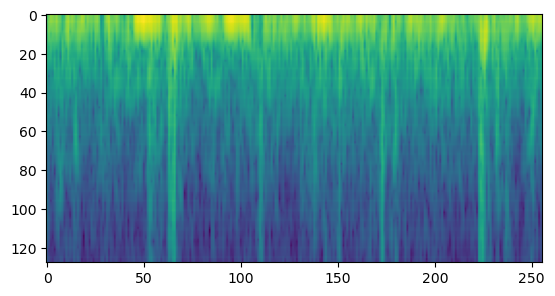

In [8]:
plt.imshow(x[0,:,:,7])

In [9]:
from sklearn.model_selection import train_test_split

total_idx = np.arange(len(train))
train_idx, val_idx = train_test_split(total_idx, test_size=0.2)
train_idx

array([ 9565,  9652, 11899, ...,  5390,   860, 15795])

In [10]:
train.iloc[train_idx]

,eeg_id,spec_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
9565,2380136004,1373665987,424.0,428.0,63252,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Seizure
9652,2402531371,1235837428,84.0,88.0,13521,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,Other
11899,2968861754,940600546,0.0,12.0,5512,0.000000,0.000000,0.071429,0.071429,0.428571,0.428571,GRDA
9479,2355114818,506283361,0.0,14.0,34298,0.000000,0.333333,0.000000,0.333333,0.000000,0.333333,LPD
11955,2981162415,1505926989,1148.0,1180.0,35627,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,LPD
...,...,...,...,...,...,...,...,...,...,...,...,...
11284,2808816465,941239612,0.0,8.0,4572,0.000000,0.000000,0.375000,0.000000,0.000000,0.625000,Other
11964,2983607405,788392355,0.0,20.0,4438,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Seizure
5390,1345588872,2005012962,0.0,58.0,19638,0.133333,0.400000,0.066667,0.200000,0.066667,0.133333,LPD
860,226164991,1183326810,0.0,6.0,35583,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,GRDA


In [21]:



def redo_classifier(model):
    num_in_features = model.get_classifier().in_features
    hidden_size = 64
    n_classes=6
    dropout_rate=.2
    d2 = .1
    for name, param in model.named_parameters():
        ijk=0
        #print (name)
        
    # Replace the existing classifier. It's named: classifier
    if "head.fc" in name:
        model.head.fc = nn.Sequential(
        nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
        nn.SiLU(),
        #nn.ReLU(inplace=True),
        #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
        #nn.GELU(),
        # nn.BatchNorm1d(hidden_size),
        nn.Dropout(d2),
        nn.Linear(hidden_size, 32, bias=True),
        #nn.Softmax(dim=0),
        # nn.BatchNorm1d(32),
        nn.Linear(32, out_features=n_classes, bias=True),
        #nn.Softmax(dim=0)
        )
    elif "fc" in name:
        model.fc = nn.Sequential(
        nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
        nn.Hardswish(),
        #nn.ReLU(inplace=True),
        #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
        #nn.GELU(),
        # nn.BatchNorm1d(hidden_size),
        nn.Dropout(d2),
        #nn.Linear(hidden_size, 32, bias=True),
        #nn.SiLU(),
        # nn.BatchNorm1d(32),
        nn.Linear(hidden_size, out_features=n_classes, bias=True),
        )
    elif "classifier" in name:
        model.classifier = nn.Sequential(
        nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
        
        #nn.ReLU(inplace=True),
        #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
        #nn.GELU(),
        # nn.BatchNorm1d(hidden_size),
        nn.Dropout(d2),
        nn.SiLU(),
        #nn.Linear(hidden_size, 32, bias=True),
        #nn.Hardswish(),
        # nn.BatchNorm1d(32),
        nn.Linear(hidden_size, out_features=n_classes, bias=True),
        )
    elif "head" in name:
        model.head = nn.Sequential(
        #nn.Dropout(dropout_rate, inplace=True),
        nn.Linear(in_features=num_in_features, out_features=hidden_size, bias=True),
        nn.Hardswish(),
        #nn.ReLU(inplace=True),
        #nn.RReLU(lower=0.05, upper=0.3333333333333333, inplace=True),
        #nn.GELU(),
        # nn.BatchNorm1d(hidden_size),
        nn.Dropout(d2),
        #nn.Linear(hidden_size, 32, bias=True),
        #nn.Hardswish(),
        # nn.BatchNorm1d(32),
        nn.Linear(hidden_size, out_features=n_classes, bias=True),
        )
    #elif "neck" in name:
    #    model.head = nn.Sequential(
    #    nn.AdaptiveAvgPool2d((64,1)),
    #    nn.Dropout(dropout_rate),
    #    nn.Linear(in_features=1, out_features=64, bias=False),
        #nn.LeakyReLU(.1,inplace=True),
        #nn.Dropout(dropout_rate),
        #nn.Linear(in_features=hidden_size, out_features=1, bias=False),
        #nn.Sigmoid())
    print (name)
    print (model)
    return model

# model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=6, in_chans=1)
# model = redo_classifier(model)
#model

import torch
import torch.nn as nn

# class CombinedModel(nn.Module):
#     def __init__(self, model1, model2, input_size1, input_size2):
#         super(CombinedModel, self).__init__()
#         self.model1 = model1
#         self.model2 = model2
#         self.fc = nn.Linear(32 * 2, 6)

#     def forward(self, x1, x2):
#         # Run the first tensor through the first model
#         output1 = self.model1(x1)

#         # Run the second tensor through the second model
#         output2 = self.model2(x2)

#         # Concatenate the outputs
#         combined_output = F.relu(torch.cat((output1, output2), dim=1))

#         # Pass the combined output through the final linear layer
#         final_output = self.fc(combined_output)

#         return final_output

# # Determine device availability
# import tqdm
# from sklearn.model_selection import train_test_split

# import albumentations as A
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f"Using device: {device}")

# # Assuming train_feats is defined and contains the training features and labels
# # total_idx = np.arange(len(train_feats))
# total_idx = np.arange(len(train))
# # np.random.shuffle(total_idx)

# gc.collect()
# criterion = nn.KLDivLoss(reduction='batchmean')
# # Cross-validation loop
# for fold in range(5):
    
#     train_idx, val_idx = train_test_split(total_idx, test_size=0.2)
#     train_gen = get_dataloader(train.iloc[train_idx], batch_size=32, shuffle=True)
#     val_gen = get_dataloader(train.iloc[val_idx], batch_size=32, shuffle=False)

#     torch.cuda.empty_cache()

#     # Initialize EfficientNet-B0 model with pretrained weights
#     #model = timm.create_model('convnext_base', pretrained=True,drop_rate=.2,drop_path_rate=.2 ,num_classes=1000, in_chans=1)
#     model = timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=8, drop_path_rate=.2,num_classes=1000,pretrained=True)
#     #model = model.eval()

#     # get model specific transforms (normalization, resize)
#     # data_config = timm.data.resolve_model_data_config(model)
#     # transforms = timm.data.create_transform(**data_config, is_training=False)
#     model = redo_classifier(model)
#     #model = nn.Sequential(nn.Conv2d(5,3,(1,1)),m1)
#     # model2 = timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=4, drop_path_rate=.2,num_classes=1000,pretrained=True)
#     # model2 = redo_classifier(model2)
#     # model = CombinedModel(model1,model2)
#     model.to(device)
    

#     optimizer = optim.NAdam(model.parameters(), lr=0.0002, weight_decay=0.02)
#     scheduler = CosineAnnealingLR(optimizer, T_max=20)

#     best_test_loss = float('inf')
#     train_losses = []
#     test_losses = []

#     print(f"Starting training for fold {fold + 1}")

#     # Training loop
#     for epoch in range(20):
#         model.train()
#         train_loss = []
#         # random_num = np.arange(len(train_idx))
#         # np.random.shuffle(random_num)
#         # train_idx = train_idx[random_num]

#         # Iterate over batches in the training set
#         count=0
#         for x,y in train_gen:
#             count=count+1
#             optimizer.zero_grad()
#             #x = transforms(x)
#             #x = x.unsqueeze(1)
#             x = x.permute(0,3,1,2)

#             train_pred = model(x.to(device))
#             #loss = KL_loss(y.to(device),train_pred)
#             loss = criterion(train_pred,y.to(device))
#             loss.backward()
#             optimizer.step()
#             train_loss.append(loss.item())
#             if count%50==0:
#                 print(loss.item())

#         epoch_train_loss = np.mean(train_loss)
#         train_losses.append(epoch_train_loss)
#         print(f"Epoch {epoch + 1}: Train Loss = {epoch_train_loss:.2f}")

#         scheduler.step()

#         # Evaluation loop
#         model.eval()
#         test_loss = []
#         with torch.no_grad():
#             for x,y in val_gen:
#                 x = x.permute(0,3,1,2)
#                 #x = x.unsqueeze(1)
#                 #x = transforms(x)

#                 test_pred = model(x.to(device))
#                 #loss = KL_loss(y.to(device),test_pred)
#                 loss = criterion(test_pred,y.to(device))
#                 test_loss.append(loss.item())

#         epoch_test_loss = np.mean(test_loss)
#         test_losses.append(epoch_test_loss)
#         print(f"Epoch {epoch + 1}: Test Loss = {epoch_test_loss:.2f}")

#         # Save the model if it has the best test loss so far
#         if epoch_test_loss < best_test_loss:
#             best_test_loss = epoch_test_loss
#             torch.save(model.state_dict(), f"efficientnet_b0_fold{fold}.pth")

#         gc.collect()

#     print(f"Fold {fold + 1} Best Test Loss: {best_test_loss:.2f}")

In [22]:
from sklearn.model_selection import KFold, GroupKFold
#import tensorflow.keras.losses as tf_loss
all_oof = []
all_true = []
criterion = nn.KLDivLoss(reduction='batchmean')
#criterion = tf_loss.KLDivergence()
gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = get_dataloader(train.iloc[train_index], batch_size=32, shuffle=True)
    val_gen = get_dataloader(train.iloc[valid_index], batch_size=32, shuffle=False)
    
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    model = timm.create_model('tf_efficientnet_b3.ns_jft_in1k', in_chans=8, drop_path_rate=.2,num_classes=1000,pretrained=True)

    model = redo_classifier(model)

    model.to(device)

    for epoch in range(10):
        model.train()
        train_loss = []

        count=0
        for x,y in train_gen:
            count=count+1
            optimizer.zero_grad()

            x = x.permute(0,3,1,2)

            train_pred = model(x.to(device))
            loss = criterion(F.log_softmax(train_pred, -1), y.to(device))
            # loss = criterion(y,train_pred.detach().cpu().numpy())
            # loss = torch.tensor(loss.numpy(), requires_grad=True)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            if count%50==0:
                print(loss.item())

        epoch_train_loss = np.mean(train_loss)
        train_losses.append(epoch_train_loss)
        print(f"Epoch {epoch + 1}: Train Loss = {epoch_train_loss:.2f}")

        scheduler.step()

        # Evaluation loop
        model.eval()
        test_loss = []
        with torch.no_grad():
            for x,y in val_gen:
                x = x.permute(0,3,1,2)
                #x = x.unsqueeze(1)
                #x = transforms(x)

                test_pred = model(x.to(device))
                #loss = KL_loss(y.to(device),test_pred)
                loss = criterion(F.log_softmax(train_pred, -1), y.to(device))
                # loss = criterion(test_pred.detach().cpu.numpy(),y)
                # loss = torch.tensor(loss.numpy())
                # test_loss.append(loss.item())

        epoch_test_loss = np.mean(test_loss)
        test_losses.append(epoch_test_loss)
        
        print(f"Epoch {epoch + 1}: Test Loss = {epoch_test_loss:.2f}")

        # Save the model if it has the best test loss so far
        if epoch_test_loss < best_test_loss:
            best_test_loss = epoch_test_loss
            torch.save(model.state_dict(), f"efficientnet_b0_fold{fold}.pth")

        gc.collect()

    print(f"Fold {fold + 1} Best Test Loss: {best_test_loss:.2f}")

    model.eval()
    test_preds = []
    with torch.no_grad():
        for x,y in val_gen:
            x = x.permute(0,3,1,2)
            test_pred = model(x.to(device))
            test_preds.append(test_pred)
    

    all_oof.append(test_preds)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    del model, oof
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
classifier.bias
EfficientNet(
  (conv_stem): Conv2dSame(8, 40, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (co

KeyboardInterrupt: 

In [14]:
torch.nn.KLDivLoss(reduction='batchmean')(F.log_softmax(train_pred, -1), y.to(device))

tensor(1.5698, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

In [ ]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for EfficientNetB2 =',cv)